# Tutorial 03 - Introduction to neural data types

## Goals

- Become aware of the processing steps typically applied to raw data acquired with a Neuralynx system
- Learn the data types used for neural data analysis
- Use the loading functions for all these files

## Data processing

### Renaming
The naming convention in our lab is:
R###-YYYY-MM-DD-filetype.extension

By default, Neuralynx will name files filetype.extension,
so the ratID and date need to be added as a prefix.
This can be done with a script,
just be careful to double-check that your script only renames the files.

### Manual annotation
Some common features that are manually annotated are:
- experimenter name
- subject ID
- session ID
- experiment time blocks

These are stored for easy access in an `info.py` file within your project folder.

### Spike sorting
Spike sorting is the process of automated and manual detection 
of individual units from a tetrode or probe recording.
See Module08 for details.

## Data files overview

A typical recording session from a Neuralynx system contains:

- ''.ncs'' ("**N**euralynx **C**ontinuously **S**ampled") files typically contain 
local field potentials (LFPs) sampled at 2kHz and filtered between 1 and 475 Hz.
- ''.t' or ''.\_t'' ("**T**etrode") files,
which are generated by MClust from the raw ''.ntt'' ("**N**euralynx **T**e**T**rode") files
contains a set of times from individual putative neurons.
- ''.nvt'' ("**N**euralynx **V**ideo **T**racking") file
contains the location of the rat as tracked by an overhead camera,
typically sampled at 30 Hz.
- ''.nev'' ("**N**euralynx **EV**ents") file 
contains timestamps and labels of events
- ''info.py'' file contains experimenter-provided information that describes this data set.

## Nept data types

Documentation for all the data types we use in Nept can be found 
[here](http://nept.readthedocs.io/en/latest/core.html).
But we'll also briefly describe them in this module.

### AnalogSignal
Genrally, data acquisition systems work by _sampling_ some quantity of interest,
so often only periodically measurements are taken.
A sampled signal is essentially a list of values (data points), taken at specific times. 
Thus, what we need to fully describe such a signal is two arrays of the same length: 
one with the timestamps and the other with the corresponding data.
For this, we use an `AnalogSignal`, which has `time` and `data` fields.

### LocalFieldPotential

A `LocalFieldPotential` is a subclass of `AnalogSignal`.

### Position

A `Position` is a subclass of `AnalogSignal`,
with some unique methods that are useful when dealing with positions.
This includes computing the `distance` between two positions, 
or computing the `speed` of the position.

### Epoch

Epochs describe occurrences that have start and stop times, 
such as a _trial_ of an experiment or the presence of a cue (e.g. a light or a tone).

### SpikeTrain

Much of neuroscience analyses attributes particular significance to action potentials, or "spikes", 
which are typically understood as all-or-none events that occur at a specific point in time. 
It is not necessary to state all the times at which there was no spike to describe a train of spikes;
it suffices to maintain a list of those times (known as "timestamps") 
at which a spike was emitted.

## Loading real data

In [3]:
# import necessary packages
%matplotlib inline
import os
import sys
import numpy as np
import nept
import matplotlib.pyplot as plt

# Define where your data folder is located
data_path = os.path.join(os.path.abspath('.'), 'data')
data_folder = os.path.join(data_path, 'R016-2012-10-03')

In [4]:
# Load the info file, which contains experiment-specific information
sys.path.append(data_folder)
import r016d3 as info

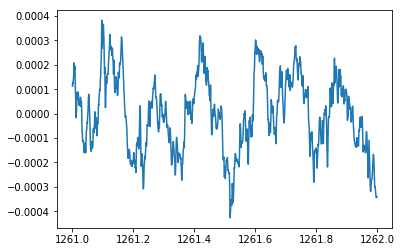

In [5]:
# Load LFP (.ncs) from rat ventral striatum (same as Module01)
lfp = nept.load_lfp(os.path.join(data_folder, info.lfp_theta_filename))

# Slice the LFP to our time of interest
start = 1261
stop = 1262
sliced_lfp = lfp.time_slice(start, stop)

# Plot the sliced LFP
plt.plot(sliced_lfp.time, sliced_lfp.data)
plt.show()

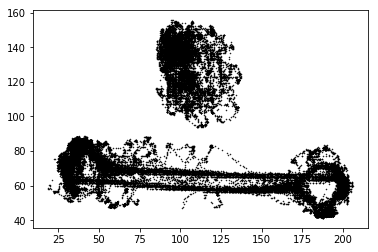

In [6]:
# Load position (.nvt) from this experiment
position = nept.load_position(os.path.join(data_folder, info.position_filename), 
                              info.pxl_to_cm)

# Plot the position
plt.plot(position.x, position.y, 'k.', ms=1)
plt.show()

In [7]:
# Load events (.nev) from this experiment
events = nept.load_events(os.path.join(data_folder, info.event_filename), 
                          info.event_labels)

# Print what events we're working with
print(events.keys())

dict_keys(['start', 'feeder0', 'feeder1', 'cue1or5', 'cue1', 'pellet1', 'cue2or4', 'pellet2', 'cue3', 'pellet3', 'pellet4', 'cue5', 'pellet5'])


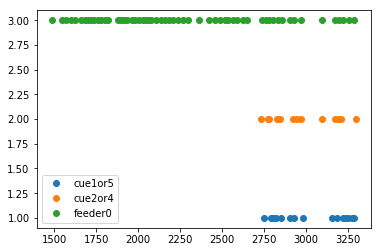

In [8]:
# Plot the events
plt.plot(events['cue1or5'], np.ones(len(events['cue1or5'])), 'o')
plt.plot(events['cue2or4'], np.ones(len(events['cue2or4']))+1, 'o')
plt.plot(events['feeder0'], np.ones(len(events['feeder0']))+2, 'o')
plt.legend(['cue1or5', 'cue2or4', 'feeder0'])
plt.show()

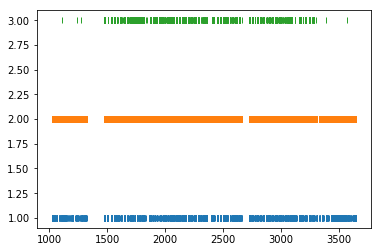

Neuron 1 has 4536 spikes
Neuron 2 has 32457 spikes
Neuron 3 has 4257 spikes


In [9]:
# Load spikes (.t and ._t) from this experiment
spikes = nept.load_spikes(data_folder)

# Plot the spikes
for idx, spiketrain in enumerate(spikes):
    plt.plot(spiketrain.time, np.ones(len(spiketrain.time))+idx, '|')
plt.show()

# Print the number of spikes emitted from each neuron
for idx, spiketrain in enumerate(spikes):
    print('Neuron', idx+1, 'has', len(spiketrain.time), 'spikes')

### Summary

Together, these three types of data can describe most data sets encountered in neuroscience. 
Putting them together in a simple visualization might look something like this, with LFP in black, 
position in cyan, epochs in red and green, and spikes in blue:

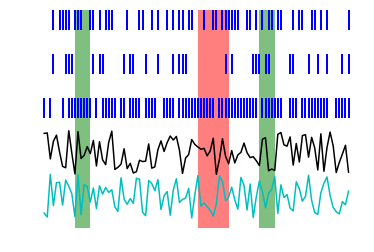

In [11]:
import random

# Construct LFP
time = np.arange(100)
data = np.array(random.sample(range(100), 100)) / 100

toy_lfp = nept.LocalFieldPotential(data, time)

# Plot the LFP
plt.plot(toy_lfp.time, toy_lfp.data, 'k')

# Construct 1D position
time = np.arange(100)
x = np.array(random.sample(range(100), 100)) / -100

toy_position = nept.Position(x, time)

# Plot the position
plt.plot(toy_position.time, toy_position.x, 'c')

# Construct some epochs, which might be something like a light cue and a sound cue
toy_light = nept.Epoch([10, 70], [15, 75])

toy_sound = nept.Epoch(50, 60)

# Plot the epochs
for light_start, light_stop in zip(toy_light.starts, toy_light.stops):
    plt.axvspan(light_start, light_stop, color='g', alpha=0.5, lw=0)

for sound_start, sound_stop in zip(toy_sound.starts, toy_sound.stops):
    plt.axvspan(sound_start, sound_stop, color='r', alpha=0.5, lw=0)

# Construct some spikes
toy_spikes = [nept.SpikeTrain(np.array(random.sample(range(100), 80))),
              nept.SpikeTrain(np.array(random.sample(range(100), 30))),
              nept.SpikeTrain(np.array(random.sample(range(100), 50)))]

# Plot the spikes
for idx, spiketrain in enumerate(toy_spikes):
    plt.plot(spiketrain.time, np.ones(len(spiketrain.time))+idx+0.5, '|', color='b', ms=20, mew=2)

# Turn off axis
plt.axis('off')

plt.show()

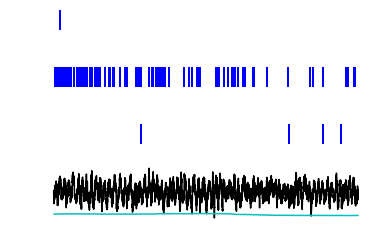

In [12]:
# With real data, this might look something more like this:

# Define our time of interest
start = 1240
stop = 1250

# Slice the LFP to our time of interest
sliced_lfp = lfp.time_slice(start, stop)

# Plot the LFP
plt.plot(sliced_lfp.time, sliced_lfp.data*1000, 'k')

# Slice the position to our time of interest
sliced_position = position.time_slice(start, stop)

# Plot the position
plt.plot(sliced_position.time, sliced_position.x*-0.001-0.3, 'c')

# Let's only work with one event, our event of interest
event_of_interest = events['pellet1']

# Slice our event to the time of interest
sliced_event = event_of_interest[(start < event_of_interest) & (event_of_interest < stop)]
if len(sliced_event) % 2 != 0: # remove last sample if odd number of events
    sliced_event = sliced_event[:-1]

# For visualization purposes, let's say this event was present for a certain amount of time
# and can be represented as an epoch, with a start and a stop
event_epoch = nept.Epoch(sliced_event[::2], sliced_event[1::2])

# Plot the epoch
for epoch_start, epoch_stop in zip(event_epoch.starts, event_epoch.stops):
    plt.axvspan(epoch_start, epoch_stop, color='r', alpha=0.5, lw=0)
   
# Slice our spikes to the time of interest
sliced_spikes = [spiketrain.time_slice(start, stop) for spiketrain in spikes]

# Plot the spikes
for idx, spiketrain in enumerate(sliced_spikes):
    plt.plot(spiketrain.time, np.ones(len(spiketrain.time))+idx, '|', color='b', ms=20, mew=2)

# Turn off axis
plt.axis('off')

plt.show()

## Real world examples

Here are two examples that illustrate some simple operations. 
You should run them and make sure you understand how the raw data is transformed.
For this, we will use a more involved data set R042-2013-08-18,
which has recordings from hippocampal CA1 neurons.

In [13]:
# import necessary packages
%matplotlib inline
import os
import sys
import numpy as np
import nept
import matplotlib.pyplot as plt
import scipy.stats

# define where your data folder is located
data_path = os.path.join(os.path.abspath('.'), 'data')
data_folder = os.path.join(data_path, 'R042-2013-08-18')

In [14]:
# load the info file, which contains experiment-specific information
sys.path.append(data_folder)
import r042d3 as info

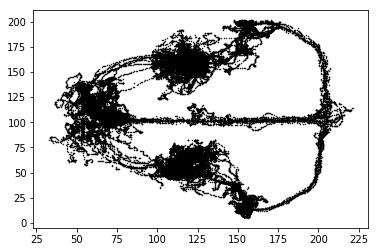

In [15]:
# Load position (.nvt) from this experiment
position = nept.load_position(os.path.join(data_folder, info.position_filename), info.pxl_to_cm)

# Plot the position
plt.plot(position.x, position.y, 'k.', ms=1)
plt.show()

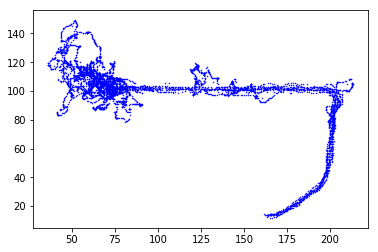

In [16]:
left = position.time_slice(info.experiment_times['left_trials'].starts, 
                           info.experiment_times['left_trials'].stops)

plt.plot(left.x, left.y, 'b.', ms=1)
plt.show()

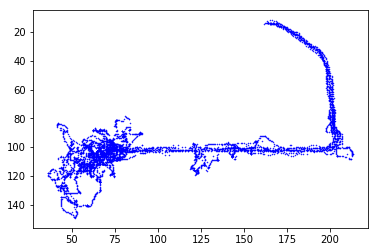

In [17]:
# This looks like right trials because the camera reverses the image.
# We can fix this by reversing the y_axis

plt.plot(left.x, left.y, 'b.', ms=1)
plt.gca().invert_yaxis()
plt.show()

Now let's look at how these data types can work together
to detect potential artifacts in the LFP.

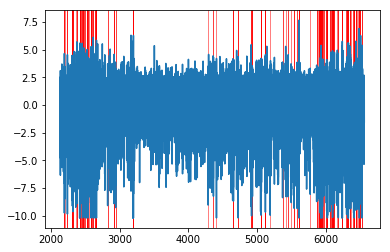

In [18]:
# Load LFP with good sharp-wave ripples
lfp_swr = nept.load_lfp(os.path.join(data_folder, info.lfp_swr_filename))

# Normalize the LFP
lfp_norm = nept.LocalFieldPotential(scipy.stats.zscore(lfp_swr.data), lfp_swr.time)

# Detect possible artifacts, save as epochs
thresh = -8
below_thresh = np.squeeze(lfp_norm.data < thresh)
below_thresh = np.hstack([[False], below_thresh, [False]]) # pad start and end to properly compute the diff

get_diff = np.diff(below_thresh.astype(int))

artifact_starts = lfp_norm.time[np.where(get_diff == 1)[0]]
artifact_stops = lfp_norm.time[np.where(get_diff == -1)[0]]

artifacts = nept.Epoch(artifact_starts, artifact_stops)

# Plot the LFP and artifact epochs
plt.plot(lfp_norm.time, lfp_norm.data)

for epoch_start, epoch_stop in zip(artifacts.starts, artifacts.stops):
    plt.axvspan(epoch_start, epoch_stop, color='r', alpha=0.5, lw=1)

plt.show()